# Welcome to HPC / AI workshop

   <a target="_blank" href="https://colab.research.google.com/github/jrossthomson/gpubootcamp/blob/master/hpc_ai/ai_science_climate/English/python/jupyter_notebook/Tropical_Cyclone_Intensity_Estimation.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run this notebook in Google Colab</a>
   

## Technical Objectives

The objective of this workshop is to give an introduction to application of Artificial Intelligence (AI) algorithms in scientific High Performance Computing (HPC) simulations. This workshop will introduce participants to fundamentals of AI and how those can be applied to different HPC simulation domains. 

## Getting started

This notebook is easiest to run in Google Colab, but it will work on any Jupyter notebook environment where a GPU can be connected. 

### Running Colab

If you want some extra help getting started with 
Google Colab, the following provides an introduction: 
[Welcome To Colaboratory](https://colab.sandbox.google.com/notebooks/intro.ipynb?utm_source=scs-index). 
However, if you are at all familiar with Jupyter Notebooks, the link below will get you started.

   <a target="_blank" href="https://colab.research.google.com/github/jrossthomson/gpubootcamp/blob/master/hpc_ai/ai_science_climate/English/python/jupyter_notebook/Tropical_Cyclone_Intensity_Estimation.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run this notebook in Google Colab</a>
 
 ### Gmail account
 
__Important__ : You will need a Gmail account to run the notebook on Golab and to save your notebook on Google Drive. [This is where you can create a Gmail account.](https://support.google.com/mail/answer/56256?hl=en)

### CNN background

If you are completely unfamiliar with Neural Networks (NN) or Machine Learning (ML) this tutorial can be a great introduction:

- [CNN Primer and Keras 101](Intro_to_DL/Part_2.ipynb))

# Get the Git Repo
**IMPORTANT** To get most of the data for this workshop, you need to clone the Git repo locally.

Another piece of data is the partially trained model data in `trained_16.h5`

In [ ]:
!git clone https://github.com/jrossthomson/gpubootcamp.git
!wget https://storage.googleapis.com/gpubootcamp_tcdata/trained_16.h5

Cloning into 'gpubootcamp'...
remote: Enumerating objects: 35303, done.
remote: Counting objects: 100% (2538/2538), done.
remote: Compressing objects: 100% (1603/1603), done.
remote: Total 35303 (delta 866), reused 2479 (delta 831), pack-reused 32765
Receiving objects: 100% (35303/35303), 1.18 GiB | 15.13 MiB/s, done.
Resolving deltas: 100% (868/868), done.
Checking out files: 100% (33719/33719), done.


# System check

Before moving forward let us check if Tensorflow backend is able to see and use GPU There are a few things to check before proceding with the tutorial.

* Do you have a GPU Running on the Colab
* Which version of TensorFlow do you have runningU

In [ ]:
# Import Necessary Libraries

from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)


print(tf.test.gpu_device_name())

!nvidia-smi -L

2.5.0
/device:GPU:0
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-474d564b-f4e5-0488-4ca6-7ae2ca02806a)


The output of the cell above will show all the available compaitable GPU on the system. If no GPU device is listed or you see an error means that there was no compaitable GPU present on the system and the future calls may run on CPU consuming more time

### To enable GPUs in Colab

On the Colab menu, "Edit" -> "Notebook Settings", a pop up will allow you to select a GPU runtime.



---

# PART 1

# Tropical cyclone intensity estimation using a Deep Convolutional Neural Network 


*Tropical cyclone intensity estimation is a challenging task as it requires domain knowledge while extracting
features, significant pre-processing, various sets of parameters obtained from satellites, and human intervention for analysis.*

*The inconsistency of results, significant pre-processing of data, the complexity of the problem domain, and problems on generalizability are some of the issues related to intensity estimation. In this Jupyter Notebook, we run a deep convolutional neural network architecture for categorizing hurricanes based on intensity using graphics
processing unit.*

*This Jupyter Notebook is a recreation of the Research Paper titled **" Tropical Cyclone Intensity Estimation Using a Deep Convolutional Neural Network "** by Ritesh Pradhan, Ramazan S. Aygun, Senior Member, IEEE, Manil Maskey, Member, IEEE, Rahul Ramachandran, Senior Member, IEEE, and Daniel J. Cecil *


## Motivation for the Problem 



##### Since hurricanes (or tropical cyclones) possess substantial threats and cause significant damage to lives and properties, studying the stages of a hurricane is essential to determine its impact. From a scientific perspective, determining an accurate TC intensity helps. 


* More accurate historical records of TCs, mainly if a technique can be consistently applied to older satellite imagery (i.e., intensity reanalysis)  

* Providing consistent intensity estimates as current intensity estimates are made via a subjective algorithm (Dvorak technique) that is applied inconsistently in different forecast areas. Initial errors are too high, especially for weak and storms that are transitioning in structure.


In this example, we use the Saffir-Simpson Hurricane Wind Scale (SSHWS) along with intensity categorization for tropical storm and tropical depression as tropical cyclone (TC) intensity categories.


Since TC intensity is based on maximum wind speeds (MWS), estimating the TC intensity by just using image content is a challenging problem. Several techniques utilize satellite imagery for estimating tropical cyclone intensity using Dvorak and deviation-angle variance technique (DAVT) techniques.

![alt_text](https://github.com/jrossthomson/gpubootcamp/blob/master/hpc_ai/ai_science_climate/English/python/jupyter_notebook/Tropical_Cyclone_Intensity_Estimation/images/cat+dvat.png?raw=1)

### Dvorak Technique : 

The Dvorak technique is a method using enhanced Infrared and/or visible satellite imagery to quantitatively estimate the intensity of a tropical system. Cloud patterns in satellite imagery normally show an indication of cyclogenesis before the storm reaches tropical storm intensity. Indications of continued development and/or weakening can also be found in the cloud features. Using these features, the pattern formed by the clouds of a tropical cyclone, expected systematic development, and a series of rules, an intensity analysis and forecast can be made.

The primary assumption of the Dvorak method is that cyclones with similar intensity tend to have a similar pattern.


This Figure shows some development patterns used by the Dvorak technique. Once a pattern is detected over 24 hours, the features such as length and banding from the storm are further analyzed to reach a particular
T-number. This relates tropical cloud structures to storm intensity. Nevertheless, this technique is not perfect and still suffers from subjective biases. Due to the inherent limitations of the empirical method used, it cannot determine subtropical cyclone intensity. Today, with the successful application of the Dvorak technique for more than 30 years along with some modifications and improvements, it is used worldwide for TC intensity estimation. The Advanced Dvorak Technique provides a nearly instantaneous estimate of TC intensity objectively. It removes a large amount of the subjectivity inherent in the process and produces errors similar to a human in most cases. But despite these attempts the errors can be high during the initial phase for weak storms that are transitioning in structure. 

**Now that we have understood the need for building a model to eliminate human errors, let us see how to approach the problem** 




---
# PART 2


# Approaching the Problem

During this lab we will be making use of the following buckets to help us understand how a Machine Learning project should be planned and executed: 

1. **Data**: To start with any ML project we need data which is pre-processed and can be fed into the network.
2. **Task**: There are many tasks present in ML, we need to make sure we understand and define the problem statement accurately.
3. **Model**: We need to build our model, which is neither too deep or complex, thereby taking a lot of computational power or too small that it could not learn the important features.
4. **Loss**: Out of the many _loss functions_ present, we need to carefully choose a _loss function_ which is suitable for the task we are about to carry out.
5. **Learning**: As we mentioned in our last notebook, there are a variety of _optimisers_ each with their advantages and disadvantages. So here we choose an _optimiser_ which is suitable for our task and train our model using the set hyperparameters.
6. **Evaluation**: This is a crucial step in the process to determine if our model has learnt the features properly by analysing how it performs when unseen data is given to it.

## Data

##### The Image data will be annotated using the Text Data to create our dataset from which the model will learn to classify the type of cyclone.


**Optional** : [Downloading Dataset](https://colab.sandbox.google.com/github/jrossthomson/gpubootcamp/blob/master/hpc_ai/ai_science_climate/English/python/jupyter_notebook/Tropical_Cyclone_Intensity_Estimation/Downloading_Images.ipynb)

**For the purposes of this lab, you do not need to download the images.**

Example of images that will be fed into our model  : 

<table><tr>
<td><img src="https://github.com/jrossthomson/gpubootcamp/blob/master/hpc_ai/ai_science_climate/English/python/jupyter_notebook/Tropical_Cyclone_Intensity_Estimation/images/example.jpg?raw=1" alt="Drawing" style="width: 320px;"/></td>
<td><img src="https://github.com/jrossthomson/gpubootcamp/blob/master/hpc_ai/ai_science_climate/English/python/jupyter_notebook/Tropical_Cyclone_Intensity_Estimation/images/example1.jpg?raw=1" alt="Drawing" style="width: 320px;"/></td>
</tr>
</table>

*Source: https://www.nrlmry.navy.mil/*

#### Each Image will be annotated to a category of Cyclone Intensity using the text data with the help of the following table :

![alt text](https://github.com/jrossthomson/gpubootcamp/blob/master/hpc_ai/ai_science_climate/English/python/jupyter_notebook/Tropical_Cyclone_Intensity_Estimation/images/cat.png?raw=1)

## Task 

There are a variety of tasks present in DL, and the task we are about to do is called Multi-class Classification. 

Here, multiple classes are present, and the model needs to classify the image into the correct class. 

The Classes here are the intensity of the tropical cyclone which will be estimated using the wind speeds of the cyclone: 
- NC ( No Category         , $\leq 20$ knots)
- TD ( Tropical Depression , $20-33$ knots)
- TS ( Topical Storm       , $34-63$ knots)
- H1 ( Category One        , $64-82$ knots)
- H2 ( Category Two        , $83-95$ knots)
- H3 ( Category Three      , $96-112$ knots)
- H4 ( Category Four       , $113-136$ knots)
- H5 ( Category Five       , $\geq 137$ knots)

##### Example of Multi-Class Classification is : 
<img src="https://github.com/jrossthomson/gpubootcamp/blob/master/hpc_ai/ai_science_climate/English/python/jupyter_notebook/Tropical_Cyclone_Intensity_Estimation/images/multi_class1.png?raw=1" alt="Drawing" style="width: 520px;"/></td>


## Model and Loss 

#### We will be using the model given in the research paper : 

The Hyper-parameters in this model ( kernel size, number of hidden layers ) is tailor-made for this project. 

![alt text](https://github.com/jrossthomson/gpubootcamp/blob/master/hpc_ai/ai_science_climate/English/python/jupyter_notebook/Tropical_Cyclone_Intensity_Estimation/images/model.png?raw=1)


### Loss Function :

We have seen about three different Multi-class loss function, they are :
- *Multi-Class Cross-Entropy Loss*
- Sparse Multi-class Cross-Entropy Loss
- Kullback Leibler Divergence Loss

We will be using the Multi-class Cross-Entropy loss function for this classification. And one can use any of the three loss function for this task.

##### Multi-Class Cross-Entropy loss : 

Before we understand how the loss value is calculated, let us understand how the outputs are produced.

When we train our model , we convert all the categories to a array of 1's and 0's. Let us assume we have a model to predict if a given image is a cat or a dog, we will then start labelling all the outputs in our dataset and assign `cat = [ 1 , 0 ]` and `dog = [ 0 , 1 ] ` and we will then train our model based on it, our model will then predict the probabilities of the output of what it thinks it to be, let's say we give it an image of a cat, we get the output to be `[ 0.87 , 0.13]` which implies that the model is 87% confident that it is a cat,but this is still not good enough we then calculate the error in this case with the following equation. 

$$ Loss = J(w) = - \frac{1}{N}\sum_{n=0}^{N} \left[ y_n \log{\hat{y_n}} + (1 - y_n) \log{(1-\hat{y_n})}  \right] $$

So ,if we try calculating the loss in our case from the equation , we will try calculating loss value for different values 

$ Loss = - \frac{1}{2}\left[ \log{0.87} + (1 - 0) \log{(1 - 0.13)} \right] = -1 * \log{0.87} = 0.060 $

If our model trained over time and if the output would be `[ 0.90 , 0.10 ]` , then let's calculate our loss again.

$ Loss = - \frac{1}{2}\left[ \log{0.90} + (1 - 0) \log{(1 - 0.10)} \right] = -1 * \log{0.90} = 0.045 $

So ,now we notice our loss value to have reduced , so using these equations our model learns to understand how it performs and updates the weights to perform better. 

### Optimizer : 

In this model, we will be using SGD Optimizer ( Stochastic Gradient Descent ) Optimizer.

##### Gradient Descent : 

Gradient descent is an optimization algorithm used to minimize some function by iteratively moving in the direction of steepest descent as defined by the negative of the gradient. 

Let us get an insight to understand how gradient descent works :

Starting at the top of the mountain, we take our first step downhill in the direction specified by the negative gradient. Next, we recalculate the negative gradient (passing in the coordinates of our new point) and take another step in the direction it specifies. We continue this process iteratively until we get to the bottom of our graph, or to a point where we can no longer move downhill–a local minimum.

<td><img src="https://github.com/jrossthomson/gpubootcamp/blob/master/hpc_ai/ai_science_climate/English/python/jupyter_notebook/Tropical_Cyclone_Intensity_Estimation/images/grad.jpg?raw=1" alt="Drawing" style="width: 420px;"/></td>

*Source: https://towardsdatascience.com/linear-regression-using-gradient-descent-97a6c8700931*

GD runs through all the samples in training set to do a single update for a parameter in a particular iteration. In SGD, on the other hand, you use only one or subset of training sample from your training set to do the update for a parameter in a particular iteration. 

Using SGD will be faster because only one training sample is used and it starts improving itself right away from the first sample.


## Training and Evaluation 

We will split our dataset into three different sets :

- Training Set
    - 72 % of the Dataset
- Test Set 
    - 18 % of the Dataset
- Validation Set 
    - 10% of the Dataset 

You are free to play around with these ratios in the next notebook.

Summary of our approach : 

![alt_text](https://github.com/jrossthomson/gpubootcamp/blob/master/hpc_ai/ai_science_climate/English/python/jupyter_notebook/Tropical_Cyclone_Intensity_Estimation/images/now.png?raw=1)


# Working with the Image Dataset 

The images are downloaded in the 'gs://gpubootcamp_tcdata' Google Cloud Storage public bucket.

### To work with the images, we need to understand the hierarchy of the Stored Images : 

The Hierarchy of this Dataset is similar to that of U.S.Naval Database for storing images, and this has been retained for storing the images as to easily scale / add more features to this.

Let's now understand how it is arranged : 


In [ ]:
!ls /content/gpubootcamp/tcdata/tcdat/tc05/ATL/12L.KATRINA/ir/geo/1km

 20050823.1245.goes12.x.ir1km.99LINVEST.30kts-1008mb-229N-752W.jpg
 20050823.1315.goes12.x.ir1km.99LINVEST.30kts-1008mb-229N-752W.jpg
 20050823.1345.goes12.x.ir1km.99LINVEST.25kts-1009mb-221N-747W.jpg
 20050823.1415.goes12.x.ir1km.99LINVEST.25kts-1009mb-221N-747W.jpg
 20050823.1445.goes12.x.ir1km.99LINVEST.25kts-1009mb-221N-747W.jpg
 20050823.1515.goes12.x.ir1km.99LINVEST.25kts-1009mb-221N-747W.jpg
 20050823.1545.goes12.x.ir1km.99LINVEST.25kts-1009mb-221N-747W.jpg
 20050823.1615.goes12.x.ir1km.99LINVEST.25kts-1009mb-221N-747W.jpg
 20050823.1645.goes12.x.ir1km.99LINVEST.25kts-1009mb-221N-747W.jpg
 20050823.1715.goes12.x.ir1km.99LINVEST.25kts-1009mb-221N-747W.jpg
 20050823.1745.goes12.x.ir1km.99LINVEST.25kts-1009mb-221N-747W.jpg
 20050823.1815.goes12.x.ir1km.99LINVEST.30kts-1008mb-229N-752W.jpg
 20050823.1845.goes12.x.ir1km.12LNONAME.30kts-1008mb-229N-752W.jpg
 20050823.1915.goes12.x.ir1km.12LNONAME.30kts-1008mb-229N-752W.jpg
 20050823.1945.goes12.x.ir1km.12LNONAME.30kts-1008mb-229N-752W

By a quick glance, we can understand the the Image Name has much information stored in it. 

Now, let us understand the format of the Data stored : 

*YYYYMMDD.HHMM*.Name of Satellite that captured the image and other relevant Data.jpg

YYYYMMDD.HHMM  -> Year Month Date. Hours Minutes 

*Now we will be using the date time provided in the image name to annotate the type of category using the text data*

# Working with the Text Data 

We will be using the Best Track Data (HURDAT2) in the Atlantic Region for the Tropical Cyclone. From its [description](http://www.nhc.noaa.gov/data/#hurdat) on the NOAA's data web page

<pre>
Atlantic hurricane database (HURDAT2) 1851-2018</span> <br>
This dataset was provided on 10 May 2019 to include the 2018 update to the best tracks.

This dataset (<a href="/data/hurdat/hurdat2-format-atlantic.pdf">known as Atlantic HURDAT2</a>) has
a comma-delimited, text format with six-hourly information on the location,
maximum winds, central pressure, and (beginning in 2004) size of all known tropical cyclones and subtropical cyclones.
The original HURDAT database has been retired.</p>
</pre>





**( Optional - [Pre-processing the Data](Pre-Processing_Text_Data.ipynb))**

This data follows a Modified CSV format because of which Pandas ( Python Library for Data Manipulation and Analysis ) can not get any useable data directly. Hence, we will be building our parser to pre-process this data and make it usable in the upcoming tasks.

The steps followed in Notebook [Pre-Processing Text Data](Pre-Processing_Text_Data.ipynb) are :

- Understanding the format of the data 
- Storing the cyclone in a dictionary
- Converting the dictionary to a Dataframe
- Restructuring the columns and making it readable
- Replacing sentinel values and removing empty strings
- Removing unwanted spaces and reindexing the Data frame
- Save this Dataframe to a CSV File

## Let us have a look at the text data :

In [ ]:
import pandas as pd
atlantic_storms= pd.read_csv('gpubootcamp/hpc_ai/ai_science_climate/English/python/jupyter_notebook/Tropical_Cyclone_Intensity_Estimation/atlantic.csv')
atlantic_storms.tail(10)
# We'll be using the Date and Time for Finding out the Velocity of the Cyclone 
# So we'll make it into a readable format

atlantic_storms['date'] = pd.to_datetime(atlantic_storms['date'].astype(str))
atlantic_storms['date'] = atlantic_storms.apply(lambda srs: srs['date'].replace(hour=int(("%04d" % srs['hours_minutes'])[:2]), minute=int(("%04d" % srs['hours_minutes'])[2:])), axis='columns')
del atlantic_storms['hours_minutes']
atlantic_storms.tail()
# Let's now save our Text Data to Use it in the Upcoming Notebooks
atlantic_storms.to_csv("atlantic_storms.csv", encoding='utf-8')
atlantic_storms.tail()['date']

51305   2018-10-11 18:00:00
51306   2018-10-12 00:00:00
51307   2018-10-12 06:00:00
51308   2018-10-12 12:00:00
51309   2018-10-12 18:00:00
Name: date, dtype: datetime64[ns]



---

# PART 3


## Understand the Model requirements

### We have seen the model to which our image will be fed

- The model described in the paper 
![alt text](https://raw.githubusercontent.com/gpuhackathons-org/gpubootcamp/master/hpc_ai/ai_science_climate/English/python/jupyter_notebook/Tropical_Cyclone_Intensity_Estimation/images/model.png)

We can see that the images need to be ( 232, 232, 3) in shape to be fed into our model.

So, we will do the following steps before feeding the image into our model.

- Step 1 : Resize Image from ( 1024, 1024 ,3) to ( 256 , 256 ,3 ) 
- Step 2 : Choose a random ( 232 , 232 , 3 ) patch from the ( 256 , 256 , 3 ) and feed into our model.

**Alternate Approach** : We can modify the model's input shape to be ( 256 x 256 x 3 ) and train it on the scaled images, but we take a ( 232 x 232 x 3 ) random patch so that our model does not expect the cyclone to be in the center and learn to understanding the mapping even with the cyclones in the sides of the images.

### Step 1 :
Let's now start with Step 1 and understand all the resizing methods available to do so.

In [ ]:
import cv2
#Read the Image Using cv2.imread()
img = cv2.imread('Tropical_Cyclone_Intensity_Estimation/images/image_shape.jpg',1)
#Changing the Color Spaces
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Print the Shape of the Image
img.shape

error: ignored

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
#Plot the image
plt.imshow(img

## Exploring different types of resizing options 

The Images can be resized in different ways. Some methods are as follows (as stated in OpenCV documentation) : 

<h3>Scaling</h3>
<p>Scaling is just resizing of the image. OpenCV comes with a function <b>cv2.resize()</a></b> for this purpose. The size of the image can be specified manually, or you can specify the scaling factor. Different interpolation methods are used. Preferable interpolation methods are <b>cv2.INTER_AREA</b> for shrinking and <b>cv2.INTER_CUBIC</b> (slow) &amp; <b>cv2.INTER_LINEAR</b> for zooming. By default, interpolation method used is <b>cv2.INTER_LINEAR</b> for all resizing purposes.

* cv2.INTER_AREA    ( Preferable for Shrinking ) 
* cv2.INTER_CUBIC   ( Preferable for Zooming but slow )
* cv2.INTER_LINEAR  ( Preferable for Zooming and the default option 



---
# Load Data


In [ ]:
def dummy():
  pass

def load_dataset(augment_fn = dummy):
    import os
    import cv2
    from datetime import datetime
    import numpy as np
    import pandas as pd
    from scipy import interpolate 
    import matplotlib.pyplot as plt

    #Variables to be used later
    filenames = []
    labels =[]
    i = 0  
    #Read CSV file using Pandas
    df = pd.read_csv('atlantic_storms.csv')

    dir ='/content/gpubootcamp/tcdata/tcdat'
    a = os.listdir(dir)

    file_path = "Dataset/Aug/"
    directory = os.path.dirname(file_path)
 
    aug = 0 
    for j in a :
        c = os.listdir(dir+'/'+j)
        for k in c :
            d = os.listdir(dir+'/'+j+'/'+k)
            for l in d :
                print(l)
                start_year= '20'+j[2:]+ '-01-01'
                end_year= '20'+j[2:]+ '-12-31'
                cyc_name = l[4:]
                mask = (df['date'] > start_year ) & (df['date'] <= end_year ) & ( df['name'] == cyc_name )
                cyc_pd = df.loc[mask]
                first = (datetime.strptime(cyc_pd['date'].iloc[0], "%Y-%m-%d %H:%M:%S"))
                last = (datetime.strptime(cyc_pd['date'].iloc[-1], "%Y-%m-%d %H:%M:%S"))
                text_time=[]
                text_vel=[]
                for q in range(len(cyc_pd['date'])):
                    text_vel.append(cyc_pd['maximum_sustained_wind_knots'].iloc[q])
                    text_time.append((datetime.strptime(cyc_pd['date'].iloc[q],"%Y-%m-%d %H:%M:%S")-first).total_seconds())
                func = interpolate.splrep(text_time,text_vel)
                e = os.listdir(dir+'/'+j+'/'+k+'/'+l+'/ir/geo/1km')
                e.sort()
                for m in e :
                    try :
                        time=(datetime.strptime(m[:13], "%Y%m%d.%H%M"))
                        name = dir+'/'+j+'/'+k+'/'+l+'/ir/geo/1km/'+m
                        if(time>first and time < last):
                            val = int(interpolate.splev((time-first).total_seconds(),func))
                            filenames.append(name)
                            if val <=20 :
                                labels.append(0)
                            elif val>20 and val <=33 :
                                labels.append(1)
                            elif val>33 and val <=63 :
                                labels.append(2)
                            elif val>63 and val <=82 :
                                labels.append(3)
                            elif val>82 and val <=95 :
                                labels.append(4)
                            elif val>95 and val <=112 :
                                labels.append(5)
                            elif val>112 and val <=136 :
                                labels.append(6)
                            elif val>136 :
                                labels.append(7)
                            i = augment_fn(name,labels[-1],filenames,labels,i)
                    except :
                        pass
    print('')
    print(len(filenames)) 
     # Shuffle The Data
    import random
    # Zip Images with Appropriate Labels before Shuffling
    c = list(zip(filenames, labels))
    random.shuffle(c)
    #Unzip the Data Post Shuffling
    filenames, labels = zip(*c)
    filenames = list(filenames)
    labels = list(labels)
    return filenames,labels
filenames,labels = load_dataset()
print(filenames)
print(labels)

07L.GORDON
08L.HELENE
27L.BETA
05L.EMILY
18L.RITA
04L.DENNIS
12L.KATRINA
25L.WILMA
07L.FRED
03L.BILL
01L.ALEX
03L.CHARLEY
09L.IVAN
06L.FRANCES
11L.JEANNE
12L.KARL
12L.KATIA
16L.OPHELIA
09L.IRENE
04L.DEAN
06L.FELIX
15L.OMAR
07L.GUSTAV
09L.IKE
02L.BERTHA
06L.EDOUARD
07L.EARL
06L.DANIELLE
12L.JULIA
11L.IGOR
13L.KARL
13L.MICHAEL


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Annotating our dataset 

Let us start by taking an example of Katrina Hurricane from 2005 and scaling it for all the Cyclones

In [ ]:
import pandas as pd
# Read the CSV we saved earlier
df = pd.read_csv('atlantic_storms.csv')
# Create a Mask to Filter our Katrina Cyclone (2005)
mask = (df['date'] > '2005-01-01') & (df['date'] <= '2006-01-01') & ( df['name'] == 'KATRINA')
# Apply the Mask to the Original Data Frame and Extract the new Dataframe
new_df = df.loc[mask]
new_df

,Unnamed: 0,index,id,name,date,record_identifier,status_of_system,latitude,longitude,maximum_sustained_wind_knots,maximum_pressure,34_kt_ne,34_kt_se,34_kt_sw,34_kt_nw,50_kt_ne,50_kt_se,50_kt_sw,50_kt_nw,64_kt_ne,64_kt_se,64_kt_sw,64_kt_nw
44500,44500,44500,AL122005,KATRINA,2005-08-23 18:00:00,NaN,TD,23.1N,75.1W,30,1008.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44501,44501,44501,AL122005,KATRINA,2005-08-24 00:00:00,NaN,TD,23.4N,75.7W,30,1007.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44502,44502,44502,AL122005,KATRINA,2005-08-24 06:00:00,NaN,TD,23.8N,76.2W,30,1007.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44503,44503,44503,AL122005,KATRINA,2005-08-24 12:00:00,NaN,TS,24.5N,76.5W,35,1006.0,60.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44504,44504,44504,AL122005,KATRINA,2005-08-24 18:00:00,NaN,TS,25.4N,76.9W,40,1003.0,60.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44505,44505,44505,AL122005,KATRINA,2005-08-25 00:00:00,NaN,TS,26.0N,77.7W,45,1000.0,60.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44506,44506,44506,AL122005,KATRINA,2005-08-25 06:00:00,NaN,TS,26.1N,78.4W,50,997.0,60.0,60.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44507,44507,44507,AL122005,KATRINA,2005-08-25 12:00:00,NaN,TS,26.2N,79.0W,55,994.0,60.0,60.0,30.0,50.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0
44508,44508,44508,AL122005,KATRINA,2005-08-25 18:00:00,NaN,TS,26.2N,79.6W,60,988.0,70.0,70.0,50.0,60.0,25.0,25.0,20.0,20.0,0.0,0.0,0.0,0.0
44509,44509,44509,AL122005,KATRINA,2005-08-25 22:30:00,L,HU,26.0N,80.1W,70,984.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here, we notice the text data to be sampled once every six hours because of which we will be forced to use interpolation techniques to find the velocity at any particular instant. 

Now determining the velocity at any time instance with this interpolated data is going to be deviated from the truth value, but we know that a class has a range of velocity so the probability that our interpolated class being correct is more realstic as compared to the former.


**We can observe, the images are taken once 30 minutes, but the text data is available once every 6 hours.  So we will be interpolating the text data to fit the curve**

In [ ]:
#Get list of Dates and Velocity from the New Dataframe
date_list = new_df['date'].tolist()
velocity_list = new_df['maximum_sustained_wind_knots'].tolist()
print(date_list[:5])
type(date_list[0])

['2005-08-23 18:00:00', '2005-08-24 00:00:00', '2005-08-24 06:00:00', '2005-08-24 12:00:00', '2005-08-24 18:00:00']


str

The Dates are in STR Format which we will be converting now to datetime format to work with.

In [ ]:
from datetime import datetime
# Get and Convert to Datetime format for the First Last recorded time of Text Data.
first = (datetime.strptime(date_list[0], "%Y-%m-%d %H:%M:%S"))
last = (datetime.strptime(date_list[-1], "%Y-%m-%d %H:%M:%S"))
print(first)
type(first)

2005-08-23 18:00:00


datetime.datetime

In [ ]:
#Changes the list from Convert everything to seconds from the first image to interpolate the data
for i in range(len(date_list)):
    date_list[i]=( (datetime.strptime(date_list[i], "%Y-%m-%d %H:%M:%S")) - first ).total_seconds()
print(date_list)

[0.0, 21600.0, 43200.0, 64800.0, 86400.0, 108000.0, 129600.0, 151200.0, 172800.0, 189000.0, 194400.0, 216000.0, 237600.0, 259200.0, 280800.0, 302400.0, 324000.0, 345600.0, 367200.0, 388800.0, 410400.0, 432000.0, 453600.0, 475200.0, 493800.0, 496800.0, 506700.0, 518400.0, 540000.0, 561600.0, 583200.0, 604800.0, 626400.0, 648000.0]


In [ ]:
# Interpolate using the Scipy Library Funciton
from scipy import interpolate
func = interpolate.splrep(date_list,velocity_list)

In [ ]:
#Getting List of Katrina Images 
import os
e = os.listdir('/content/gpubootcamp/tcdata/tcdat/tc05/ATL/12L.KATRINA/ir/geo/1km')
# Sort images by time
e.sort()
x=[]
y=[]
for m in e :
    try :
        #Strip the Time Data from image and convert it the a datetime type.
        time_img=(datetime.strptime(m[:13], "%Y%m%d.%H%M"))
        # If the Image is taken between the available text data
        if(time_img>=first and time_img <= last):
            # Get Interpolated Value for that time and Save It 
            value = int(interpolate.splev((time_img-first).total_seconds(),func))
            x.append((time_img-first).total_seconds())
            y.append(value)
    except :
       pass 
print("Done")

Done


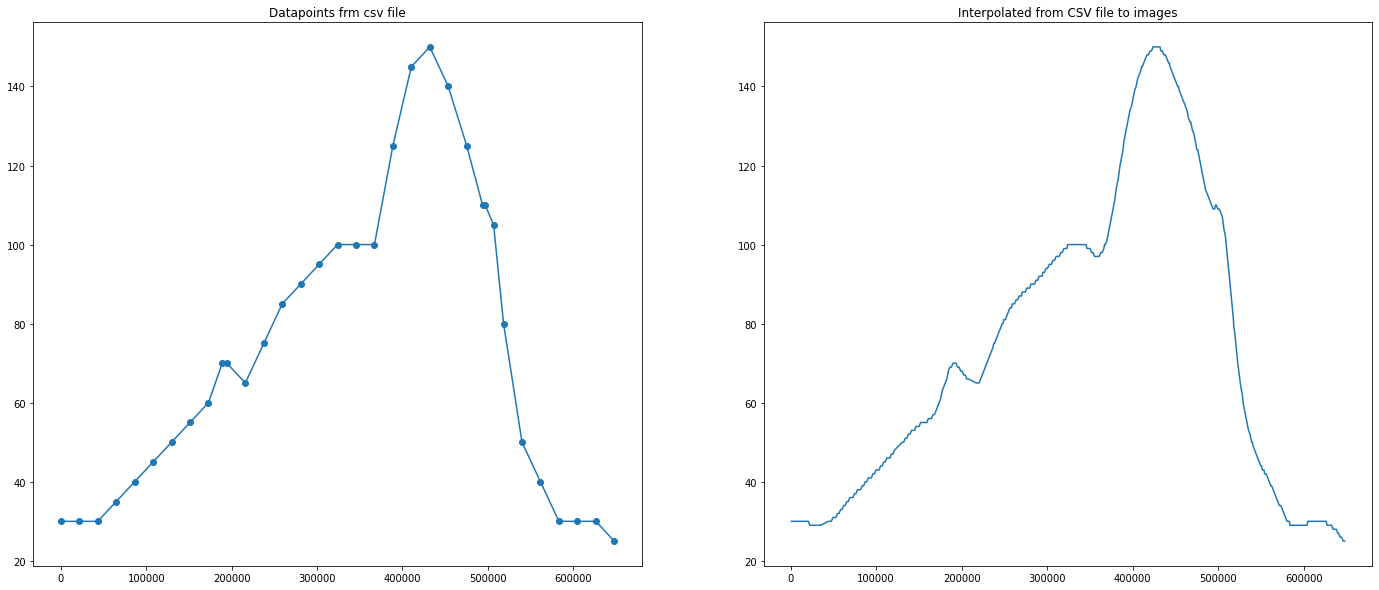

In [ ]:
import matplotlib.pyplot as plt
# Plot All the Saved Data Points
f = plt.figure(figsize=(24,10))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.title.set_text('Datapoints frm csv file')
ax2.title.set_text('Interpolated from CSV file to images')
ax.plot(date_list,velocity_list,'-o')
ax2.plot(x,y)

**Now we have interpolated and found relevant velocity for all images between the recorded text timeframe. Let us now use it for training our Model.**

# Wrapping Things Up :

### Preparing the Dataset

#####  All the above modules are joined together and make It into a single function to load data

In [ ]:
def make_test_set(filenames,labels,val=0.1):
    classes = 8
    j=0
    val_filenames=[]
    val_labels=[]
    new = [int(val*len(filenames)/classes)]*classes
    print(new)
    try:
        for i in range(len(filenames)):
            if(new[labels[i]]>0):
                val_filenames.append(filenames[i])
                val_labels.append(labels[i])
                new[labels[i]] = new[labels[i]]-1
                del filenames[i]
                del labels[i]
    except :
        pass
    
     # Shuffle The Data
    import random
    # Zip Images with Appropriate Labels before Shuffling
    c = list(zip(val_filenames, val_labels))
    random.shuffle(c)
    #Unzip the Data Post Shuffling
    val_filenames, val_labels = zip(*c)
    val_filenames = list(val_filenames)
    val_labels = list(val_labels)
    from collections import Counter
    print(Counter(labels))
    return val_filenames,val_labels  
val_filenames , val_labels = make_test_set(filenames,labels,val=0.1)


[344, 344, 344, 344, 344, 344, 344, 344]
Counter({2: 7936, 3: 5339, 1: 3803, 4: 2934, 5: 2336, 6: 2178, 7: 204, 0: 100})


## Understand our dataset :

We can see the following lines from the Output : 

`[344, 344, 344, 344, 344, 344, 344, 344]` and `{2: 7936, 3: 5339, 1: 3803, 4: 2934, 5: 2336, 6: 2178, 7: 204, 0: 100}`

This is the distribution of our validation set and training set over it's classes. 

For the validation set we use *Stratified Validation* set so that our validation set nearly respresent the whole class. 


In [ ]:
#Make train test set
test = 0.2
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(filenames, labels, test_size=test, random_state=1)

## One-Hot Encoding 

`y_train` is a list containing data from 0-7 such as [ 2,4,5,....] but our Model Needs an Input of Array for Each Output as as 1D vector  :

2 --- > [ 0 , 0 , 1 , 0 , 0 , 0 , 0 , 0] 

4 --- > [ 0 , 0 , 0 , 0 , 1 , 0 , 0 , 0] 


This is encoded as such because keeping the other values 0 is necessary for the model to find the model Loss and use backpropagation for making it learn the _Weight Matrix_.

The below given image is an example of One-Hot Encoding :

![alt text](https://github.com/jrossthomson/gpubootcamp/blob/master/hpc_ai/ai_science_climate/English/python/jupyter_notebook/Tropical_Cyclone_Intensity_Estimation/images/one_hot.jfif?raw=1)

Reference : [What is One Hot Encoding and How to Do It](https://medium.com/@michaeldelsole/what-is-one-hot-encoding-and-how-to-do-it-f0ae272f1179)

In [ ]:
import tensorflow as tf
y_train = tf.one_hot(y_train,depth=8)
y_test = tf.one_hot(y_test,depth=8)
val_labels = tf.one_hot(val_labels,depth=8)

In [ ]:
def parse_function(filename, label):
    image_string = tf.io.read_file(filename)

    #Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image_string, channels=3)

    #This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    #Resize Image 
    image = tf.image.resize(image, [232, 232])
    
    return image, label
def make_dataset(train_in,test_in,val_in):
    import tensorflow as tf
    train = tf.data.Dataset.from_tensor_slices((train_in[0], train_in[1]))
    train = train.shuffle(len(train_in[0]))
    train = train.map(parse_function,num_parallel_calls=8)
    train = train.batch(train_in[2])
    train = train.prefetch(1)
    test = tf.data.Dataset.from_tensor_slices((test_in[0], test_in[1]))
    test = test.shuffle(len(test_in[0]))
    test = test.map(parse_function, num_parallel_calls=8)
    test = test.batch(test_in[2])
    test = test.prefetch(1)
    val = tf.data.Dataset.from_tensor_slices((val_in[0],val_in[1] ))
    val = val.map(parse_function, num_parallel_calls=8)
    val = val.batch(val_in[2])
    val = val.prefetch(1)
    return train,test,val

train,test,val = make_dataset((x_train,y_train,128),(x_test,y_test,32),(val_filenames,val_labels,32))
print(test)
print(train)
print(val)
print(val_labels)

<PrefetchDataset shapes: ((None, 232, 232, 3), (None, 8)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 232, 232, 3), (None, 8)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 232, 232, 3), (None, 8)), types: (tf.float32, tf.float32)>
tf.Tensor(
[[0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(2752, 8), dtype=float32)


## Defining our Model

![alt_text](https://github.com/jrossthomson/gpubootcamp/blob/master/hpc_ai/ai_science_climate/English/python/jupyter_notebook/Tropical_Cyclone_Intensity_Estimation/images/model.png?raw=1)

We will be Implementing this model in Keras using the following code

In [ ]:
import numpy as np
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
tf.random.set_seed(1337)

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten ,Dropout, MaxPooling2D
from tensorflow.keras import backend as K 

#Reset Graphs and Create Sequential model
K.clear_session()
model = Sequential()
#Convolution Layers

model.add(Conv2D(64, kernel_size=10,strides=3, activation='relu', input_shape=(232,232,3)))
model.add(MaxPooling2D(pool_size=(3, 3),strides=2))
model.add(Conv2D(256, kernel_size=5,strides=1,activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=2))
model.add(Conv2D(288, kernel_size=3,strides=1,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=1))
model.add(Conv2D(272, kernel_size=3,strides=1,padding='same',activation='relu'))
model.add(Conv2D(256, kernel_size=3,strides=1,activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=2))
model.add(Dropout(0.5))
model.add(Flatten())

#Linear Layers 

model.add(Dense(3584,activation='relu'))
model.add(Dense(2048,activation='relu'))
model.add(Dense(8, activation='softmax'))

# Print Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 75, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 256)       409856    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 288)       663840    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 288)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 272)       7

### Compiling and Training our Model

We will be using the following : 

- Optimizer : SGD ( Stochastic Gradient Descent ) with parameters mentioned in the research paper.
    - Learning Rate : 0.001
    - Momentum : 0.9
- Loss Function : Categorical Cross Entropy ( Used in Multi-class classification ) 
- Metrics : We will be using two metrics to determine how our model performs 
    - Accuracy  : Number of Predictions correct / Total number of Predictions
    - Top -2 Accuracy : Top-2 accuracy means that any of your model 2 highest probability answers must match the expected answer.


In [ ]:
import functools

# Include Top-2 Accuracy Metrics 
top2_acc = functools.partial(tensorflow.keras.metrics.top_k_categorical_accuracy, k=2)
top2_acc.__name__ = 'top2_acc'

#Define Number of Epochs
epochs = 4

#But Training our model from scratch will take a long time
#So we will load a partially trained model to speedup the process 
model.load_weights("trained_16.h5")

# Optimizer
sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9)


#Compile Model with Loss Function , Optimizer and Metrics
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy, 
              optimizer=sgd,
              metrics=['accuracy',top2_acc])

# Train the Model 
trained_model = model.fit(train,
          epochs=epochs,
          verbose=1,
          validation_data=val)

# Test Model Aganist Validation Set
score = model.evaluate(test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/4
156/156 [==============================] - 23s 145ms/step - loss: 0.5931 - accuracy: 0.7831 - top2_acc: 0.9240 - val_loss: 0.6936 - val_accuracy: 0.7515 - val_top2_acc: 0.9113
Epoch 2/4
156/156 [==============================] - 23s 148ms/step - loss: 0.5393 - accuracy: 0.8000 - top2_acc: 0.9353 - val_loss: 0.7338 - val_accuracy: 0.7504 - val_top2_acc: 0.9124
Epoch 3/4
156/156 [==============================] - 25s 161ms/step - loss: 0.4810 - accuracy: 0.8254 - top2_acc: 0.9488 - val_loss: 0.6014 - val_accuracy: 0.8085 - val_top2_acc: 0.9386
Epoch 4/4
156/156 [==============================] - 23s 147ms/step - loss: 0.4291 - accuracy: 0.8468 - top2_acc: 0.9551 - val_loss: 0.4963 - val_accuracy: 0.8180 - val_top2_acc: 0.9524
Test loss: 0.2881021499633789
Test accuracy: 0.9055578112602234


### Visualisations

Let us now visualise how our model perfromed during the training process : 

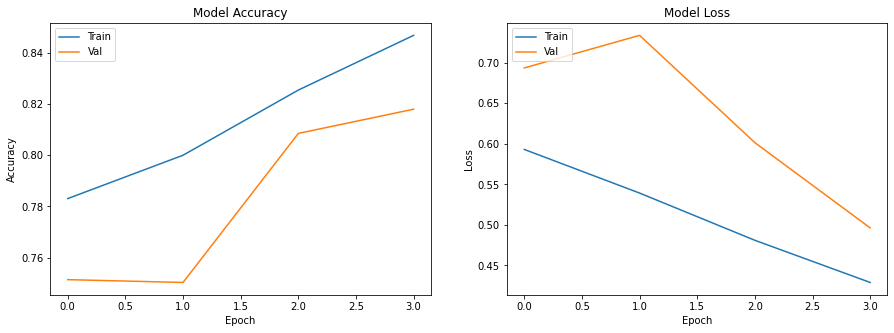

In [ ]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(121)
ax.plot(trained_model.history['accuracy'])
ax.plot(trained_model.history['val_accuracy'])
ax.set_title('Model Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Val'])

ax2 = f.add_subplot(122)
ax2.plot(trained_model.history['loss'])
ax2.plot(trained_model.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Val'],loc= 'upper left')

plt.show()

## Confusion Matrix :

A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known. 

Here , the rows display the predicted class and the columns are the truth value of the classes.From this we can estimate how our model performs over different classes which would in turn help us determine how our data should be fed into our model.




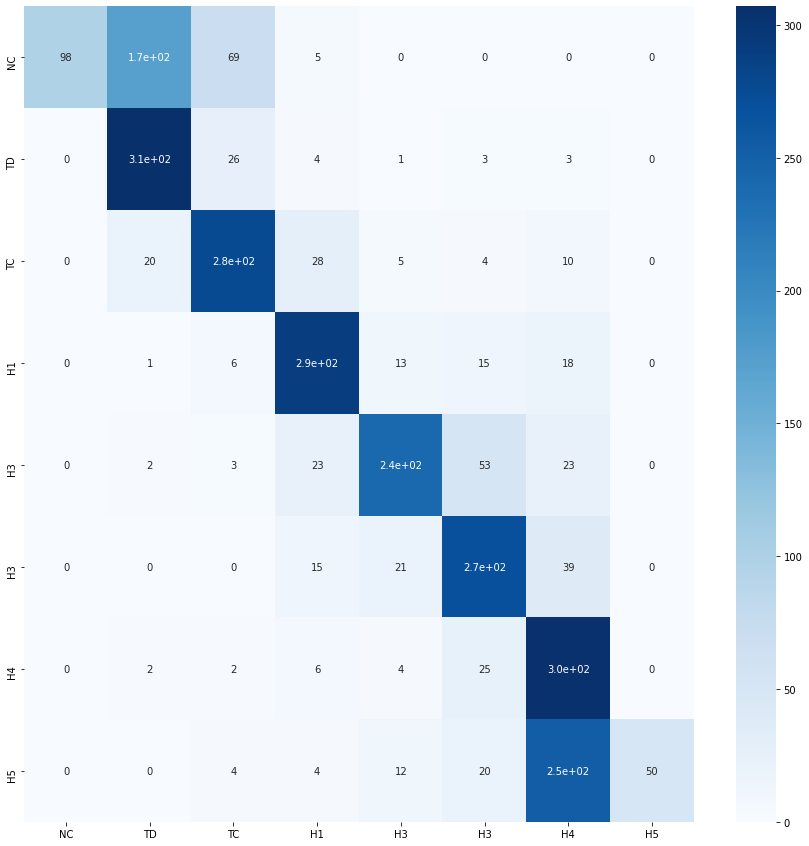

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
import pandas as pd

#Plotting a heatmap using the confusion matrix
pred = model.predict(val)
p = np.argmax(pred, axis=1)
y_valid = np.argmax(val_labels, axis=1, out=None)
results = confusion_matrix(y_valid, p) 
classes=['NC','TD','TC','H1','H3','H3','H4','H5']
df_cm = pd.DataFrame(results, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (15,15))

sn.heatmap(df_cm, annot=True, cmap="Blues")

**Congralutions on running your first model. Now In the next notebook , let us try to understand the drawbacks of this model and make it better :**


We can notice that the validation accuracy is lesser than the training accuracy. This is because the model is not properly Regularized and the possible reasons are : 

**Not enough data-points / Imbalanced classes**

Using different techniques we will be regulating and normalising the model in the upcoming notebook.





---
# PART 4


# Understanding the drawbacks

```python3
Simply put, a machine learning model is only as good as the data it is fed with
```
We have achieved an accuracy nearly of ~85% running with 4 epochs. Now we will try to increase the accuracy by taking a closer look at the dataset and images. We can observe the following from our previous notebook : 

First thing that we will notice from the category count is that the number of images per category is very un-uniform with ratios of TC: H5 **greater than 1:20**, This imbalance can bias the vision of our CNN model because predicting wrong on the minority class wouldn't impact the model a lot as the class contribution is less than 5% of the dataset.

The same can be shown also by the heatmap we obtained in the previous notebook : Notice Most of Classes with higher data was predicted correctly and the minority class was more mis-predicted than the other classes 
![alt_text](https://github.com/jrossthomson/gpubootcamp/blob/master/hpc_ai/ai_science_climate/English/python/jupyter_notebook/Tropical_Cyclone_Intensity_Estimation/images/heatmap.png?raw=1)


Let us see now how we solve that problem using data augmentation : 

## Working out the solution

## Data Augmentation 

To decrease the un-uniformity, we will be flipping and rotating images to compensate for the lack of data for class with less samples: 

![alt text](https://github.com/jrossthomson/gpubootcamp/blob/master/hpc_ai/ai_science_climate/English/python/jupyter_notebook/Tropical_Cyclone_Intensity_Estimation/images/augment.png?raw=1)


We will be using OpenCV for Flipping and Image Rotations. 

``` python
cv2.flip(img,0)
cv2.flip(img,1)
cv2.warpAffine(img, cv2.getRotationMatrix2D(center, 90, 1.0), (h, w))
cv2.warpAffine(img, cv2.getRotationMatrix2D(center, 180, 1.0), (w, h))
cv2.warpAffine(img, cv2.getRotationMatrix2D(center, 270, 1.0), (h, w))
```

There are other ways to counter data imbalance such as Class weightage, Oversampling, SMOTE etc..

# Training the Model with Data Augmentation 


We create a new function called `augmentation(name,category,filenames,labels,i)` and here we add more samples to Category which have imbalanced data.  

In [ ]:
import os
file_path = "/content/Dataset/Aug/"
directory = os.path.dirname(file_path)

try:
  os.mkdir("Dataset")
  os.mkdir("Dataset/Aug")
  print("Directory Created")
except:
  print("Directory Exists")

Directory Created


In [ ]:
import sys
import cv2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

def load_image(name,interpolation = cv2.INTER_AREA):
    img=cv2.imread(name,1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    inter_area = cv2.resize(img,(256,256),interpolation=interpolation)
    start_pt= np.random.randint(24,size=2)
    end_pt = start_pt + [232,232]
    img = inter_area[start_pt[0]:end_pt[0],start_pt[1]:end_pt[1]]
    return img

# Define the Augmentation Function 
def augmentation(name,category,filenames,labels,i):
    # Important Constants
    file_path = "Dataset/Aug/"
    images = []
    (h, w) = (232,232)
    center = (w / 2, h / 2)
    angle90 = 90
    angle180 = 180
    angle270 = 270
    scale = 1.0
    img = load_image(name , interpolation = cv2.INTER_LINEAR)
    
    
    if category == 0 :
        images.append(cv2.flip(img,0))
    elif category == 1 :
        pass
    elif category == 2 :
        pass
    elif category == 3 :
        pass
    elif category == 4 :
        pass
    elif category == 5 :
        pass
    elif category == 6 :
        pass
    elif category == 7 :
        images.append(cv2.flip(img,0))
        
        
    for j in range(len(images)):
        cv2.imwrite(file_path+str(i+j)+'.jpeg',images[j])
        filenames.append(file_path+str(i+j)+'.jpeg')
        labels.append(category)
    i = i + len(images)
    return i

**We pass this function to our `load_dataset()` function to generate these augmentations. **

Kindly wait for a couple of minutes while augments the images.

In [ ]:
filenames,labels = load_dataset(augment_fn = augmentation)

07L.GORDON
08L.HELENE
27L.BETA
05L.EMILY
18L.RITA
04L.DENNIS
12L.KATRINA
25L.WILMA
07L.FRED
03L.BILL
01L.ALEX
03L.CHARLEY
09L.IVAN
06L.FRANCES
11L.JEANNE
12L.KARL
12L.KATIA
16L.OPHELIA
09L.IRENE
04L.DEAN
06L.FELIX
15L.OMAR
07L.GUSTAV
09L.IKE
02L.BERTHA
06L.EDOUARD
07L.EARL
06L.DANIELLE
12L.JULIA
11L.IGOR
13L.KARL
13L.MICHAEL

28574


In [ ]:
# Set the Size of the Validation set
val_filenames , val_labels = make_test_set(filenames,labels,val=0.1)

[357, 357, 357, 357, 357, 357, 357, 357]
Counter({2: 7923, 3: 5326, 1: 3790, 4: 2921, 5: 2323, 6: 2165, 7: 739, 0: 531})


In [ ]:
#Make train test set 
test = 0.1
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(filenames, labels, test_size=test, random_state=1)

In [ ]:
import tensorflow as tf
y_train = tf.one_hot(y_train,depth=8)
y_test = tf.one_hot(y_test,depth=8)
val_labels = tf.one_hot(val_labels,depth=8)

In [ ]:
# Make Dataset compatible with Tensorflow Data Pipelining.
train,test,val = make_dataset((x_train,y_train,128),(x_test,y_test,32),(val_filenames,val_labels,32))

# The model described in the paper :

Now we will be using the model described in the paper to evaluate it's accuracy on the new dataset.

![alt_text](https://github.com/jrossthomson/gpubootcamp/blob/master/hpc_ai/ai_science_climate/English/python/jupyter_notebook/Tropical_Cyclone_Intensity_Estimation/images/model.png?raw=1)

In [ ]:
import numpy as np
tf.random.set_seed(1337)

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten ,Dropout, MaxPooling2D
from tensorflow.keras import backend as K 

#Reset Graphs and Create Sequential model

K.clear_session()
model = Sequential()
#Convolution Layers

model.add(Conv2D(64, kernel_size=10,strides=3, activation='relu', input_shape=(232,232,3)))
model.add(MaxPooling2D(pool_size=(3, 3),strides=2))
model.add(Conv2D(256, kernel_size=5,strides=1,activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=2))
model.add(Conv2D(288, kernel_size=3,strides=1,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=1))
model.add(Conv2D(272, kernel_size=3,strides=1,padding='same',activation='relu'))
model.add(Conv2D(256, kernel_size=3,strides=1,activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=2))
model.add(Dropout(0.5))
model.add(Flatten())

#Linear Layers 

model.add(Dense(3584,activation='relu'))
model.add(Dense(2048,activation='relu'))
model.add(Dense(8, activation='softmax'))

# Print Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 75, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 256)       409856    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 288)       663840    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 288)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 272)       7

In [ ]:
import functools
# Include Top-2 Accuracy Metrics 
top2_acc = functools.partial(tensorflow.keras.metrics.top_k_categorical_accuracy, k=2)
top2_acc.__name__ = 'top2_acc'

#Define Number of Epochs
epochs = 4

#But Training our model from scratch will take a long time
#So we will load a partially trained model to speedup the process 
model.load_weights("trained_16.h5")

# Optimizer
sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9)


#Compile Model with Loss Function , Optimizer and Metrics
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy, 
              optimizer=sgd,
              metrics=['accuracy',top2_acc])

# Train the Model 
trained_model = model.fit(train,
          epochs=epochs,
          verbose=1,
          validation_data=val)

# Test Model Aganist Validation Set
score = model.evaluate(test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Epoch 1/4
181/181 [==============================] - 27s 146ms/step - loss: 0.6704 - accuracy: 0.7594 - top2_acc: 0.9089 - val_loss: 0.5330 - val_accuracy: 0.8165 - val_top2_acc: 0.9394
Epoch 2/4
181/181 [==============================] - 27s 148ms/step - loss: 0.5647 - accuracy: 0.7946 - top2_acc: 0.9308 - val_loss: 0.3922 - val_accuracy: 0.8708 - val_top2_acc: 0.9576
Epoch 3/4
181/181 [==============================] - 27s 150ms/step - loss: 0.4882 - accuracy: 0.8308 - top2_acc: 0.9435 - val_loss: 0.4313 - val_accuracy: 0.8536 - val_top2_acc: 0.9520
Epoch 4/4
181/181 [==============================] - 26s 144ms/step - loss: 0.4232 - accuracy: 0.8516 - top2_acc: 0.9566 - val_loss: 0.2874 - val_accuracy: 0.9020 - val_top2_acc: 0.9702
Test loss: 0.258732408285141
Test accuracy: 0.9082425832748413


### Visualisations

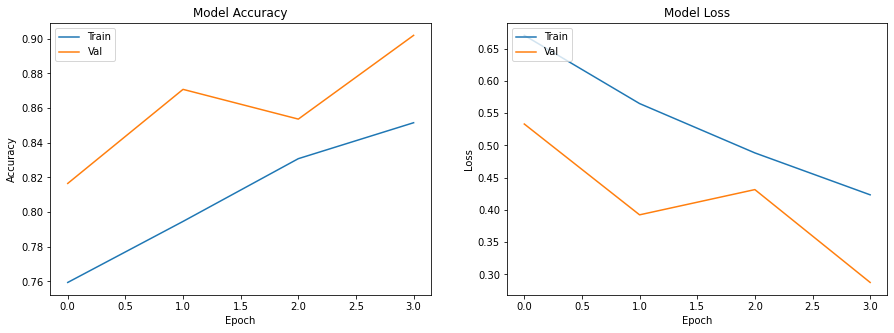

In [ ]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(121)
ax.plot(trained_model.history['accuracy'])
ax.plot(trained_model.history['val_accuracy'])
ax.set_title('Model Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Val'])

ax2 = f.add_subplot(122)
ax2.plot(trained_model.history['loss'])
ax2.plot(trained_model.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Val'],loc= 'upper left')

plt.show()

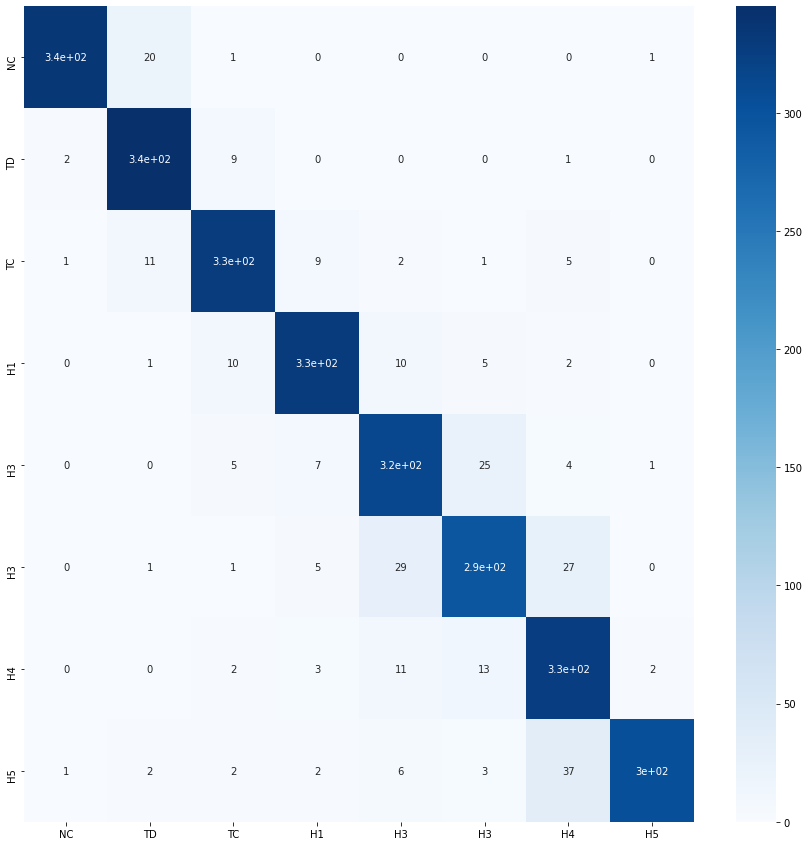

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
import pandas as pd

#Plotting a heatmap using the confusion matrix

pred = model.predict(val)
p = np.argmax(pred, axis=1)
y_valid = np.argmax(val_labels, axis=1, out=None)
results = confusion_matrix(y_valid, p) 
classes=['NC','TD','TC','H1','H3','H3','H4','H5']
df_cm = pd.DataFrame(results, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (15,15))

sn.heatmap(df_cm, annot=True, cmap="Blues")

Let us now save our Model and the trained weights for future usage :

In [ ]:
#Save Our Model 
model.save('cyc_pred.h5')



---
# PART 5


<H1>Competition</H1>

In this exercise participant need to tune and work on improving overall acuracy of our model. 

To help you get started by pointing out some obvious ways in which you can make the model more efficient. 

- Epochs  
- Batch Size 
- Optimizers : We have used SGD as a optimizer. Participant can try applying other optimizer and test to obtain quick convergence.
- Data Augmentation : Remember, we mentioned we have an imbalanced dataset. You could try differnet augmentation techniques for the minority classes.
- Model : If you have exploited all the bbove methods to improve your model, you can change the model by adding more Layers to it and see if that improves that accuracy.

Note, before you start tweaking and training your model ,it would be worthwhile to refer to these to see how they affect your model : 

[Epochs impact on Overfitting](https://datascience.stackexchange.com/questions/27561/can-the-number-of-epochs-influence-overfitting ) 


[Effect of Batch Size on Training Dynamics](https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e)

[Introduction to Optimizers](https://algorithmia.com/blog/introduction-to-optimizers)